In [1]:
spark.version

'3.1.3'

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [5]:
!pip uninstall -y nltk 
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.7
Uninstalling nltk-3.7:
  Successfully uninstalled nltk-3.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.0 MB/s eta 0:00:00a 0:00:01


In [6]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [8]:
bucket_write = 'msca-bdp-students-bucket'

In [9]:
sim_df = spark.read.parquet('gs://' + bucket_write + '/shared_data/paraut/tweets/')

22/12/07 06:40:45 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
sim_df1 = sim_df.select(['text', 'Organization', 'id', 'retweeted_status'])

In [11]:
org_tweets = sim_df1.withColumn("retweeted_status", when(sim_df1.retweeted_status.isNull(), sim_df1.retweeted_status))

In [26]:
celeb_main = org_tweets.filter(org_tweets.Organization == 'Celebrity')

In [27]:
celeb_main2 = celeb_main.select(['text'])

In [28]:
text = celeb_main2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [29]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
# df_text.limit(5)

In [30]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
# df_tokens.limit(5).toPandas()

In [31]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [32]:
# df_vectorize.limit(5).toPandas()

In [33]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [34]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
# df_hashed_text.limit(5)

In [35]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [36]:
# df_dups_text_comp.limit(5).toPandas()

In [37]:
df_dups_50 = df_dups_text
# df_dups_text.limit(5).toPandas()

In [38]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

Total records:  1806
Duplicate tweets based on { 0.7 } jaccard distance:  36
Unique tweets based on { 0.7 } jaccard distance:  0.7 :  1770


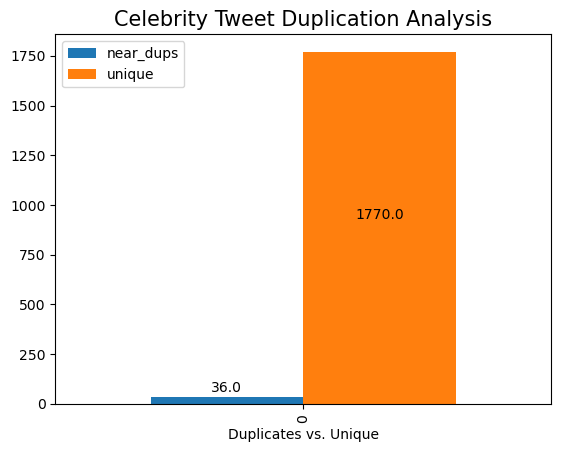

In [39]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Celebrity Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 